In [1]:
import os
from tqdm import tqdm

## Reading data

In [3]:
messages_dir = 'messages/part'
messages = []

for i in range(1, 11):
    messages_part = []
    for message_filename in os.listdir(messages_dir + str(i)):
        message_file = open(messages_dir + str(i) + "/" + message_filename, "r")
        subject = message_file.readline()[9:-1]
        message_file.readline()
        text = message_file.readline()[:-1]
        is_spam = 2 if 'spmsg' in message_filename else 1
        messages_part.append([subject + ' ' + text, is_spam])
    messages.append(messages_part)

## Accuracy score 

In [4]:
def get_accuracy_score(y_true, y_predicted):
    return sum(1 if y_true_i == y_predicted_i else 0 for y_true_i, y_predicted_i in zip(y_true, y_predicted)) / len(y_true)

## Cross Validation

In [6]:
import math
from collections import defaultdict

In [70]:
class BayesClassifier:
    def __init__(self, alpha, gram_len, lambdas):
        self.classes = defaultdict(int)
        self.frequencies = defaultdict(int)
        self.probabilities = defaultdict(int)
        self.grams = set()
        self.alpha = alpha
        self.gram_len = gram_len
        self.lambdas = lambdas
        self.log_probs = defaultdict(float)
        self.back_log_probs = defaultdict(float)

    def create_n_grams(self, labels, lines):
        for label, line in zip(labels, lines):
            line_grams = set()
            self.classes[label] += 1
            for i in range(len(line) - self.gram_len + 1):
                gram = ' '.join(line[i: i + self.gram_len])
                self.grams.add(gram)
                line_grams.add(gram)
            for gram in line_grams:
                self.frequencies[label, gram] += 1

    def create_conditional_probs(self):
        for label in self.classes.keys():
            for gram in self.grams:
                self.probabilities[gram, label] = (self.frequencies[label, gram] + self.alpha) / (
                        self.classes[label] + self.alpha * 2)
                self.log_probs[gram, label] = math.log(self.probabilities[gram, label])
                self.back_log_probs[gram, label] = math.log(1 - self.probabilities[gram, label])

    def fit(self, X, y):
        self.create_n_grams(y, X)
        self.create_conditional_probs()
    #p(x,y) = p(y)*p(x/y)

    def predict(self, X):
        resulting_probs = {}
        grams = [' '.join(str(x) for x in X[i: i + self.gram_len] for i in range(len(X) - self.gram_len + 1))]
        for label in self.classes.keys():
            if self.classes[label] != 0:
                resulting_probs[label] = math.log(self.classes[label] / sum(self.classes.values()) * self.lambdas[
                    label - 1]) + self.get_back_conditional_probs(label, grams)
            else:
                resulting_probs[label] = 0
        max_prob = max(i for i in resulting_probs.values() if i < 0)
        for label, prob in resulting_probs.items():
            resulting_probs[label] = math.exp(prob - max_prob)
        sum_prob = sum(resulting_probs.values())
        for label, prob in resulting_probs.items():
            resulting_probs[label] = prob / sum_prob
        return resulting_probs

    def get_back_conditional_probs(self, label, grams):
        prob = 0
        for w in self.grams:
            if w in grams:
                if self.probabilities[w, label] != 0:
                    prob += self.log_probs[w, label]
                else:
                    prob = 0
                    break
            else:
                if self.probabilities[w, label] != 1:
                    prob += self.back_log_probs[w, label]
                else:
                    prob = 0
                    break
        return prob

In [8]:
from collections import Counter 

def most_frequent(l, count): 
    occurence_count = Counter(l) 
    return [x[0] for x in occurence_count.most_common(count)]

In [58]:
def cross_validate(messages, classifier_params):
    scores = []
    for i in range(len(messages)):
        test = messages[i]
        train = messages[:i] + messages[i + 1:]
        X_train = []
        y_train = []
        for messages_part in train:
            for message in messages_part:
                X_train.append(most_frequent(message[0].split(), 25))
                y_train.append(message[1])
        classifier = BayesClassifier(*classifier_params)
        classifier.fit(X_train, y_train)
        y_true = []
        y_predicted = []
        for message in test:
            X_test = message[0].split()
            X_test = most_frequent(X_test, 25)
            y_test = message[1]
            y_true.append(y_test)
            res = classifier.predict(X_test)
            y_predicted.append(max(res, key=res.get))
        scores.append(get_accuracy_score(y_true, y_predicted))
    return sum(scores) / len(scores)

## Hyperparameter Optimization

In [59]:
def hyperparameter_optimization():
    best_accuracy_score = -1
    best_params = None
    for alpha in [1e-5, 1e-2]:
        for gram_len in [1, 2, 3]:
            accuracy_score = cross_validate(messages, [alpha, gram_len, [1, 1]])
            if best_accuracy_score < accuracy_score:
                best_accuracy_score = accuracy_score
                best_params = [alpha, gram_len, [1, 1]]
    print('Best accuracy score is {0} for params {1}'.format(best_accuracy_score, best_params))
    return best_accuracy_score, best_params

## Model analysis

In [60]:
hyperparameter_optimization()

Best accuracy score is 0.9770642201834863 for params [0.01, 1, [1, 1]]


(0.9770642201834863, [0.01, 1, [1, 1]])

## RocCurve

In [61]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

In [74]:
classifier = BayesClassifier(0.01, 1, [1, 1])
X_train = []
y_train = []
for messages_part in messages:
    for message in messages_part:
        X_train.append(message[0].split())
        y_train.append(message[1])
classifier.fit(X_train, y_train)
y_pred_probabilities = []
for X in X_train:
    p1 = list(classifier.predict(X).values())[0]
    p2 = list(classifier.predict(X).values())[1]
    y_pred_probabilities.append([p1, p2])

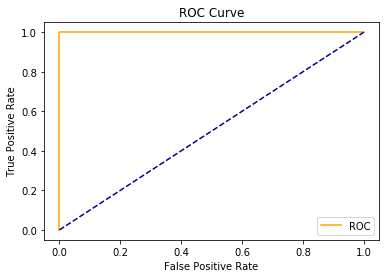

In [63]:
y_true = [y_i - 1 for y_i in y_train]
plot_roc_curve(y_true, [y[1] for y in y_pred_probabilities])

## No FalsePositive

In [71]:
from sklearn.metrics import confusion_matrix
accuracy = []
power = 1
fp = -1
while fp != 0:
    classifier = BayesClassifier(0.01, 1, [10 ** power, 1])
    X_train = []
    y_train = []
    for messages_part in messages[:-1]:
        for message in messages_part:
            X_train.append(most_frequent(message[0].split(), 25))
            y_train.append(message[1])  
    X_test = []
    y_test = []
    for message in messages[-1]:
        X_test.append(most_frequent(message[0].split(), 25))
        y_test.append(message[1])
    classifier.fit(X_train, y_train)
    y_pred = []
    for X in X_test:
        res = classifier.predict(X_test)
        y_pred.append(max(res, key=res.get))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy.append(get_accuracy_score(y_test, y_pred))
    print("%2d: TN = %3d, FP = %2d, FN = %2d, TP = %3d" % (power, tn, fp, fn, tp))
    power += 1

 1: TN =   0, FP = 61, FN =  0, TP =  48
 2: TN =  61, FP =  0, FN = 48, TP =   0


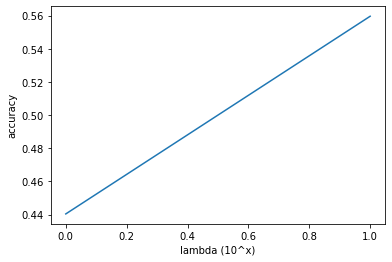

In [73]:
plt.plot(range(0, power - 1), accuracy)
plt.xlabel('lambda (10^x)')
plt.ylabel('accuracy')
plt.show()